
# Zonal Statistics with Geopandas and Rasterio

**Brek Chiles, 2025**


In [1]:
# Import modules
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio import plot
from rasterio.mask import mask
import rasterstats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_map_utils.core.scale_bar import scale_bar


### Data Handling


In [2]:
# Set directory and file paths
ipynb_dir = os.getcwd()
boundary_dir = os.path.join(ipynb_dir, "Inputs", "Boundary")
roads_dir = os.path.join(ipynb_dir, "Inputs", "Roads")
dem_dir = os.path.join(ipynb_dir, "Inputs", "DEM")

#  Raster
raster_elev= os.path.join(dem_dir, "King_Co_2021_Ext.tif")
hillshade = os.path.join(dem_dir, "King_Co_2021_SR.tif")
slope_perc = os.path.join(dem_dir, "King_Co_2021_Ext_Perc.tif")

# Vector/Geometry
boundary = os.path.join(boundary_dir, "Redmond_Study_Area.shp")
roads_shp = os.path.join(roads_dir, "Redmond_Roads.shp")

# Check file paths
ipynb_dir, raster_elev, hillshade, slope_perc, boundary, roads_shp

('c:\\Users\\brekc\\No-License-Required-Zonal-Statistics-With-GeoPandas',
 'c:\\Users\\brekc\\No-License-Required-Zonal-Statistics-With-GeoPandas\\Inputs\\DEM\\King_Co_2021_Ext.tif',
 'c:\\Users\\brekc\\No-License-Required-Zonal-Statistics-With-GeoPandas\\Inputs\\DEM\\King_Co_2021_SR.tif',
 'c:\\Users\\brekc\\No-License-Required-Zonal-Statistics-With-GeoPandas\\Inputs\\DEM\\King_Co_2021_Ext_Perc.tif',
 'c:\\Users\\brekc\\No-License-Required-Zonal-Statistics-With-GeoPandas\\Inputs\\Boundary\\Redmond_Study_Area.shp',
 'c:\\Users\\brekc\\No-License-Required-Zonal-Statistics-With-GeoPandas\\Inputs\\Roads\\Redmond_Roads.shp')

In [3]:
# Rasters
redmond_elev = rio.open(raster_elev)
redmond_hillshade = rio.open(hillshade)
redmond_slope_perc = rio.open(slope_perc)

# Vectors/Geometries
redmond_roads = gpd.read_file(roads_shp)
study_area = gpd.read_file(boundary)


**Check Coordinate Reference Systems (CRS) and units**


In [4]:
redmond_elev.crs

CRS.from_wkt('PROJCS["NAD83(HARN) / Washington North (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4152"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",47],PARAMETER["central_meridian",-120.833333333333],PARAMETER["standard_parallel_1",48.7333333333333],PARAMETER["standard_parallel_2",47.5],PARAMETER["false_easting",1640416.667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2926"]]')

In [5]:
redmond_elev.crs.linear_units

'US survey foot'

In [6]:
redmond_roads.crs

<Projected CRS: EPSG:2926>
Name: NAD83(HARN) / Washington North (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Washington - counties of Chelan; Clallam; Douglas; Ferry; Grant north of approximately 47°30'N; Island; Jefferson; King; Kitsap; Lincoln; Okanogan; Pend Oreille; San Juan; Skagit; Snohomish; Spokane; Stevens; Whatcom.
- bounds: (-124.79, 47.08, -117.02, 49.05)
Coordinate Operation:
- name: SPCS83 Washington North zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
redmond_roads.crs.axis_info[0].unit_name

'US survey foot'


A GeoDataFrame (gdf) is a Pandas DataFrame (df) with Shapely objects stored in a geometry column. The following code cells will leverage regular Pandas functions and methods to perform data manipulation.



**.copy():** The .copy() method duplicates a gdf/df and allows users to both modify copied data and preserve the original data.


In [8]:
# Inspect fields of redmond_roads
redmond_roads.columns.values

array(['StreetName', 'FromStreet', 'ToStreet', 'StreetWidt', 'ConstYear',
       'd_Classifi', 'd_Ownershi', 'd_Status', 'd_DataSour', 'd_InsideCi',
       'FromLeft', 'ToLeft', 'FromRight', 'ToRight', 'LeftCity',
       'RightCity', 'LeftZip', 'RightZip', 'Side', 'Exclude', 'lz_evn',
       'lz_odd', 'la_evn', 'la_odd', 'StreetNa_1', 'FireArteri',
       'surface', 'd_ConstBy', 'MaxSpeedLi', 'CreatedBy', 'DateCreate',
       'ModifiedBy', 'DateModifi', 'StAlias1', 'StAlias2', 'StAlias3',
       'AssetID', 'LucityAuto', 'd_AssetTyp', 'CalcLength', 'Location',
       'GlobalID', 'StAlias4', 'Shape_STLe', 'geometry'], dtype=object)

In [9]:
# Calculate road segment lengths
redmond_roads['length_ft'] = redmond_roads.geometry.length

In [10]:
# Create a copy of the Redmond Roads gdf with selected columns
redmond_roads_gdf = redmond_roads[['StreetName', 'FromStreet', 'ToStreet', 'length_ft', 'geometry']].copy()
redmond_roads_gdf.head()

,StreetName,FromStreet,ToStreet,length_ft,geometry
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"LINESTRING (1324032.261 259389.496, 1324373.77..."
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"LINESTRING (1327052.127 259309.378, 1327082.21..."
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"LINESTRING (1321723.019 259046.304, 1321724.01..."
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"LINESTRING (1317925.193 258700.349, 1318097.10..."
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"LINESTRING (1320654.273 258647.865, 1320690.97..."


In [11]:
# What is the geometry column?
type(redmond_roads_gdf['geometry'])

geopandas.geoseries.GeoSeries


### Zonal Statistics with Geopandas and Rasterio 

This section builds a tool to extract zonal statistics from a raster dataset with zones or boundaries. The zonal statistics tool will use Geopandas to access geometries and write statistics for new fields. Numpy functions can calculate statistics from a masked array created with Rasterio. Let's calculate zonal statistics for a single zone first, then build functions to iterate over multiple zones.



**Zonal Statistics Example for Longest Road Segment**


In [12]:
# Get geometry of the longest road segment
longest_road = redmond_roads_gdf.loc[redmond_roads_gdf['length_ft'].idxmax()]
longest_road
# Series to DataFrame
#longest_road.to_frame().T

StreetName                                            SR 520 EB
FromStreet                                                 None
ToStreet                                                   None
length_ft                                            3934.58935
geometry      LINESTRING (1321704.8840703 246026.14160313646...
Name: 861, dtype: object

In [13]:
# Check the geometry type
longest_road.geometry.geom_type

'LineString'

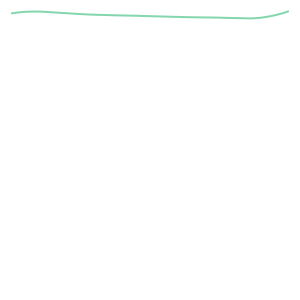

In [14]:
# What does the polygon look like?
longest_road.geometry

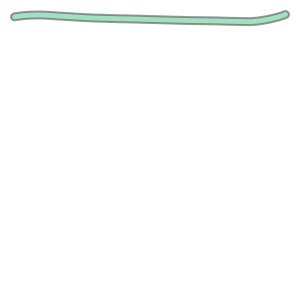

In [15]:
# Buffer the road segment by 50 feet to create a polygon
longest_road_buffer = longest_road.geometry.buffer(50)
longest_road_buffer

In [16]:
# Use the mask function from Rasterio to create an array of the slope % raster
longest_road_buffer_mask, longest_road_buffer_mask_transform = mask(
    dataset=redmond_slope_perc,
    shapes=[longest_road_buffer],
    crop=True,
    all_touched=True,
    filled=False,
    indexes=1
)

# longest_road_buffer_mask is the numpy array with masked values
longest_road_buffer_mask

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [17]:
# longest_road_buffer_mask_transform describes the transformation from pixel coordinates to geographic coordinates
longest_road_buffer_mask_transform

Affine(1.4997300069147081, 0.0, 1321654.3578012493,
       0.0, -1.499817855808718, 246110.17556905968)

In [18]:
# Check the shape (columns and rows) of the masked array
longest_road_buffer_mask.shape

(136, 2681)

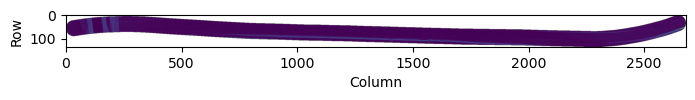

In [19]:
# Quick plot of the masked array
plt.figure(figsize=(8, 6))
plt.imshow(longest_road_buffer_mask)
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

In [20]:
# Count the number of nonmasked pixels/cells in the longest road
longest_road_buffer_mask.count()

np.int64(181310)

In [21]:
# Calculate the minimum, maximum, and mean slope % values in the longest road buffer
f"Min - {longest_road_buffer_mask.min():.4f} %, Max - {longest_road_buffer_mask.max():.4f} %, Mean - {longest_road_buffer_mask.mean():.4f} %"

'Min - 0.0000 %, Max - 334.3548 %, Mean - 9.3648 %'


Extracting zonal statistics from zones individually can be costly if you are working with large datasets and multiple zones. We will use a function to create the masked arrays over the entire geometry column. The **.apply()** function will apply the masked array function and Numpy functions to obtain zonal statistics.


In [22]:
# Function for extracting statistics from masked slope array
def slope_masked_array(geom, data=redmond_slope_perc):
    slope_masked, slope_mask_transform = mask(dataset=data, shapes=[geom],
                                  crop=True, all_touched=True, filled=False, indexes=1)
    return slope_masked


The count of cells within a zone is another useful statistic to have, let's use another function to extract that.


In [23]:
# Function for counting nonmasked raster cells
def cell_count(rio_array):
    cells = rio_array.count()
    return cells


## **The Moment You've All Been Waiting For**



Before extracting zonal statistics for roads in Central Redmond, we should consider applying a buffer to the geometries. Buffering roadway centerlines will better represent the surrounding topography in the zonal statistics.

**Note:** The geometries will now be polygons instead of lines/linestrings.


In [24]:
# Copy the roads gdf, then buffer the geometry to 50 feet
redmond_roads_gdf_50ft = redmond_roads_gdf.copy()
redmond_roads_gdf_50ft['geometry'] = redmond_roads_gdf_50ft.buffer(50)
redmond_roads_gdf_50ft.head()

,StreetName,FromStreet,ToStreet,length_ft,geometry
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ..."
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ..."
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ..."
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2..."
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ..."


In [25]:
# Extract slope % statistics for each road segment
redmond_roads_gdf_50ft['cell_count'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(cell_count)
redmond_roads_gdf_50ft['min_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.min)
redmond_roads_gdf_50ft['max_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.max)
redmond_roads_gdf_50ft['mean_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.mean)
redmond_roads_gdf_50ft['std_slope_%'] = redmond_roads_gdf_50ft.geometry.apply(slope_masked_array).apply(np.std)
redmond_roads_gdf_50ft

,StreetName,FromStreet,ToStreet,length_ft,geometry,cell_count,min_slope_%,max_slope_%,mean_slope_%,std_slope_%
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",19043,0.252375,239.195038,16.312830,17.956337
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11697,0.119728,57.442135,9.930423,5.799605
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12569,0.026078,76.771843,6.441449,5.364962
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28831,0.015105,65.882812,9.364263,7.850290
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41993,0.030135,91.548363,11.089444,10.760332
...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6895,0.114909,95.899071,16.057082,18.487624
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12676,0.058000,93.011971,30.400230,23.194566
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15968,0.046519,103.248390,10.763486,13.938007
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8977,0.123534,73.322433,14.729890,15.649314



Reading values between zones can be confusing at times. Try classifying slope grades to help interpret the results.


In [26]:
# Create a classification field based on a choice list and conditions (slope_grade_thresholds)
slope_grade_thresholds = [
	(redmond_roads_gdf_50ft['mean_slope_%'] >= 0) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 9),
	(redmond_roads_gdf_50ft['mean_slope_%'] > 9) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 15),
	(redmond_roads_gdf_50ft['mean_slope_%'] > 15) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 30),
	(redmond_roads_gdf_50ft['mean_slope_%'] > 30) & (redmond_roads_gdf_50ft['mean_slope_%'] <= 60)
]

# Choice list
slope_grade_classifications = [1, 2, 3, 4]
slope_grade_classifications_2 = ['Gentle', 'Moderate', 'Steep', 'Very Steep']

# Make a new field to classify roadways based on mean slope
redmond_roads_gdf_50ft['slope_class'] = np.select(slope_grade_thresholds, slope_grade_classifications)

# Change the values in the slope_class field to slope_grade_classifications_2
redmond_roads_gdf_50ft['slope_class'] = redmond_roads_gdf_50ft['slope_class'].replace(
	dict(zip(slope_grade_classifications, slope_grade_classifications_2))
)

# Check the new field
redmond_roads_gdf_50ft

,StreetName,FromStreet,ToStreet,length_ft,geometry,cell_count,min_slope_%,max_slope_%,mean_slope_%,std_slope_%,slope_class
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",19043,0.252375,239.195038,16.312830,17.956337,Steep
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11697,0.119728,57.442135,9.930423,5.799605,Moderate
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12569,0.026078,76.771843,6.441449,5.364962,Gentle
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28831,0.015105,65.882812,9.364263,7.850290,Moderate
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41993,0.030135,91.548363,11.089444,10.760332,Moderate
...,...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6895,0.114909,95.899071,16.057082,18.487624,Steep
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12676,0.058000,93.011971,30.400230,23.194566,Very Steep
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15968,0.046519,103.248390,10.763486,13.938007,Moderate
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8977,0.123534,73.322433,14.729890,15.649314,Moderate


In [27]:
# Select roadways based on slope class
roads_select = redmond_roads_gdf_50ft[redmond_roads_gdf_50ft['slope_class'] == 'Very Steep']
roads_select

,StreetName,FromStreet,ToStreet,length_ft,geometry,cell_count,min_slope_%,max_slope_%,mean_slope_%,std_slope_%,slope_class
1155,180th AVE NE,180th AVE NE,N of NE 95th CT,573.638403,"POLYGON ((1327817.535 253164.136, 1327815.834 ...",29649,1.143156,284.365265,33.384254,31.638954,Very Steep
1232,REDMOND WAY,W LK SAMMAMISH PKWY,BEAR CREEK PKWY,122.352756,"POLYGON ((1320069.93 248457.214, 1320098.917 2...",8156,0.142511,288.771057,31.154807,42.969207,Very Steep
1369,162nd PL NE,NE 122nd ST,NE 124th ST,712.797816,"POLYGON ((1322987.079 261896.102, 1322984.716 ...",34004,0.252580,170.312759,31.205693,23.828060,Very Steep
1514,NE 70th ST,188th AVE NE,191st AVE NE,876.347277,"POLYGON ((1331350.843 246116.609, 1331355.513 ...",43174,0.096582,111.215485,33.246225,24.289707,Very Steep
1515,NE 70th ST,192nd AVE NE,NE 70th ST,425.565039,"POLYGON ((1332639.63 246114.642, 1332644.529 2...",22827,0.058290,114.848167,31.015815,24.002500,Very Steep
1518,192nd AVE NE,NE 69th CIR,NE 70th ST,323.997423,"POLYGON ((1332163.696 246068.142, 1332163.961 ...",18252,0.153466,122.421890,43.058343,26.097107,Very Steep
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12676,0.058000,93.011971,30.400230,23.194566,Very Steep



### Zonal Statistics Map


In [28]:
# Create masked arrays for plotting
hillshade_array = redmond_hillshade.read(1, masked=True)

# Plotting extent
plt_extent = rio.plot.plotting_extent(redmond_hillshade)

Text(134.21556206492733, 0.5, 'Northing')

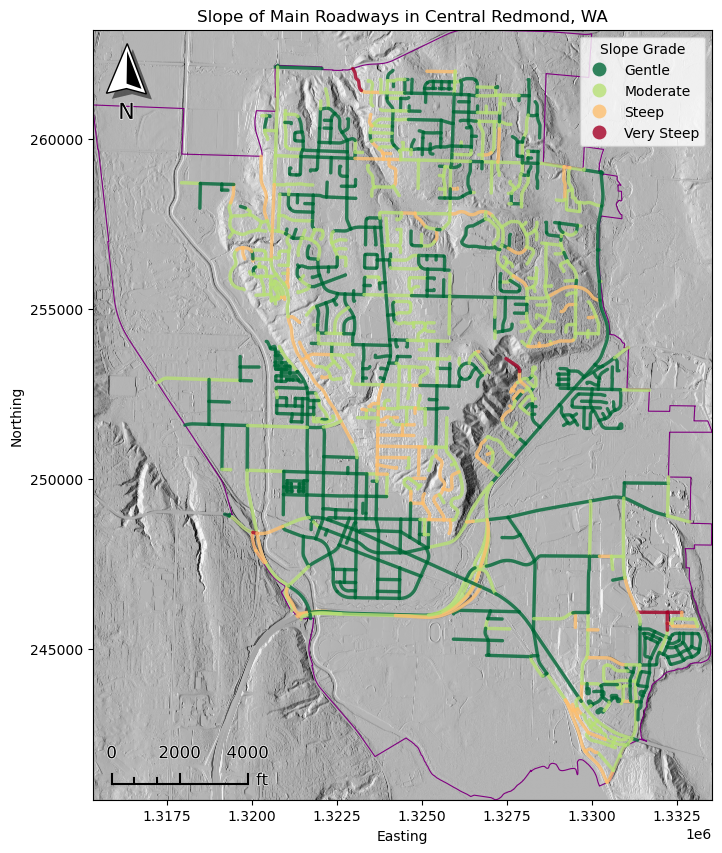

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data and study area
hillshade_plot = ax.imshow(hillshade_array, cmap='gray', extent=plt_extent)
study_area.plot(ax=ax, color='None', edgecolor='purple', linewidth=0.8)

# Plot the buffered roadways with slope classification
redmond_roads_gdf_50ft.plot(
    ax=ax,
    column='slope_class',
    cmap='RdYlGn_r',
    alpha=0.8,
    linewidth=0.3,
    legend=True,
    legend_kwds={'title': 'Slope Grade'}
)

# Add a legend, north arrow, and scale bar
north_arrow(ax, location="upper left", rotation={"crs": redmond_roads_gdf.crs, "reference": "center"})
scale_bar(ax, location="lower left", style="ticks", bar={"projection": redmond_roads_gdf.crs, "unit": "ftUS", "max": 4000, "major_div": 2, "minor_div":3})
plt.title('Slope of Main Roadways in Central Redmond, WA')

# Add title and labels
plt.xlabel('Easting')
plt.ylabel('Northing')


### Rasterstats Comparison

Rasterstats is another Python module that calculates zonal statistics with boundaries or zones and raster datasets as arrays. Unlike the Geopandas and Rasterio zonal statistics tool we built, Rasterstats accepts a list of statistics. Rasterstats offers a concise option for zonal statistic analysis, but requires a customized Python environment at the time this repository was published. We will compare results between Rasterstats and the Geopandas-Rasterio method as a way to validate the Geopandas-Rasterio method.


In [30]:
# Create a statistics list for cell count, mean, and standard deviation (std)
stats=['count', 'mean', 'std']

In [31]:
# Create masked arrays for slope percentage
slope_perc_array = redmond_slope_perc.read(1, masked=True)

In [32]:
# Use zonal_stats to calculate statistics for the buffered roads and use the masked slope array to set the other inputs
redmond_roads_50ft_stats = rasterstats.zonal_stats(redmond_roads_gdf_50ft, slope_perc_array,
                                            affine=redmond_slope_perc.transform, nodata=redmond_slope_perc.nodata, stats=stats)

In [33]:
# Create a Pandas df from the Rasterstats results
rasterstats_df = pd.DataFrame(redmond_roads_50ft_stats, columns=stats)
rasterstats_df

,count,mean,std
0,18676,16.362584,18.080509
1,11440,9.874168,5.675154
2,12276,6.410288,5.351420
3,28318,9.432054,7.865597
4,41280,11.067454,10.761327
...,...,...,...
1522,6742,16.006290,18.463713
1523,12396,30.572715,23.143212
1524,15654,10.761567,13.932122
1525,8794,14.657086,15.633074


In [34]:
# Assuming both dfs have a common 'ID' column, join rasterstats_df to redmond_roads_gdf_50ft
redmond_roads_gdf_50ft_rs_join = redmond_roads_gdf_50ft.join(rasterstats_df)
redmond_roads_gdf_50ft_rs_join

,StreetName,FromStreet,ToStreet,length_ft,geometry,cell_count,min_slope_%,max_slope_%,mean_slope_%,std_slope_%,slope_class,count,mean,std
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",19043,0.252375,239.195038,16.312830,17.956337,Steep,18676,16.362584,18.080509
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11697,0.119728,57.442135,9.930423,5.799605,Moderate,11440,9.874168,5.675154
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12569,0.026078,76.771843,6.441449,5.364962,Gentle,12276,6.410288,5.351420
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28831,0.015105,65.882812,9.364263,7.850290,Moderate,28318,9.432054,7.865597
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41993,0.030135,91.548363,11.089444,10.760332,Moderate,41280,11.067454,10.761327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6895,0.114909,95.899071,16.057082,18.487624,Steep,6742,16.006290,18.463713
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12676,0.058000,93.011971,30.400230,23.194566,Very Steep,12396,30.572715,23.143212
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15968,0.046519,103.248390,10.763486,13.938007,Moderate,15654,10.761567,13.932122
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8977,0.123534,73.322433,14.729890,15.649314,Moderate,8794,14.657086,15.633074



The results from Rasterstats are slightly different from what we obtained earlier with the Geopandas-Rasterio method and NumPy functions. The next cells will compare the results and determine if raster cells within the zones are following similar data trends from each zonal statistics method. Here's an early hint: find the 'all_touched' argument for rasterstats.zonal_stats() and rasterio.mask.mask().


In [35]:
# Clean up the df by renaming columns and dropping unnecessary columns
redmond_roads_gdf_50ft_rs_join.rename(columns={
    'cell_count': 'count_gpd-rio',
    'mean_slope_%': 'mean_gpd-rio',
    'std_slope_%': 'std_gpd-rio',
    'count': 'count_rstats',
    'mean': 'mean_rstats',
    'std': 'std_rstats'
}, inplace=True)

# Drop columns
redmond_roads_gdf_50ft_rs_join.drop(columns=['min_slope_%', 'max_slope_%', 'slope_class'], inplace=True)

# Check the cleaned df
redmond_roads_gdf_50ft_rs_join

,StreetName,FromStreet,ToStreet,length_ft,geometry,count_gpd-rio,mean_gpd-rio,std_gpd-rio,count_rstats,mean_rstats,std_rstats
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",19043,16.312830,17.956337,18676,16.362584,18.080509
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11697,9.930423,5.799605,11440,9.874168,5.675154
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12569,6.441449,5.364962,12276,6.410288,5.351420
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28831,9.364263,7.850290,28318,9.432054,7.865597
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41993,11.089444,10.760332,41280,11.067454,10.761327
...,...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6895,16.057082,18.487624,6742,16.006290,18.463713
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12676,30.400230,23.194566,12396,30.572715,23.143212
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15968,10.763486,13.938007,15654,10.761567,13.932122
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8977,14.729890,15.649314,8794,14.657086,15.633074



**.describe():** The .describe() method summarizes statistics for a Pandas DataFrame or GeoPandas GeoDataFrame. We will use .describe() on each zonal statistic to compare the distribution of values between the GeoPandas-Rasterio (gpd-rio) and Rasterstats (rstats) methods.
 

In [36]:
# Create a df to compare statistics of mean slope values
mean_stats_df = pd.DataFrame({
    'GeoPandas-Rasterio Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].describe(),
    'Rasterstats Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_rstats'].describe()
})

mean_stats_df['Difference'] = mean_stats_df['GeoPandas-Rasterio Mean Slope'] - mean_stats_df['Rasterstats Mean Slope']
mean_stats_df

,GeoPandas-Rasterio Mean Slope,Rasterstats Mean Slope,Difference
count,1527.000000,1527.000000,0.000000
mean,9.399264,9.366920,0.032344
std,4.475711,4.465950,0.009762
min,2.668554,2.634842,0.033712
25%,6.159740,6.150750,0.008990
50%,8.365041,8.319216,0.045825
75%,11.593763,11.580883,0.012881
max,43.058343,43.421248,-0.362905


In [37]:
# Create a df to compare statistics of counts
counts_stats_df = pd.DataFrame({
    'GeoPandas-Rasterio Cell Count': redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].describe(),
    'Rasterstats Cell Count': redmond_roads_gdf_50ft_rs_join['count_rstats'].describe()
})

counts_stats_df['Difference'] = counts_stats_df['GeoPandas-Rasterio Cell Count'] - counts_stats_df['Rasterstats Cell Count']
counts_stats_df

,GeoPandas-Rasterio Cell Count,Rasterstats Cell Count,Difference
count,1527.000000,1527.000000,0.000000
mean,20652.481991,20233.616241,418.865750
std,15917.185247,15644.507226,272.678021
min,1816.000000,1753.000000,63.000000
25%,11754.000000,11484.000000,270.000000
50%,16172.000000,15802.000000,370.000000
75%,24503.500000,24021.000000,482.500000
max,181310.000000,178420.000000,2890.000000


In [38]:
# Create a df that is the difference between the GeoPandas-Rasterio and Rasterstats results
difference_df = redmond_roads_gdf_50ft_rs_join.copy()
difference_df['count_diff'] = difference_df['count_gpd-rio'] - difference_df['count_rstats']
difference_df['mean_diff'] = difference_df['mean_gpd-rio'] - difference_df['mean_rstats']
difference_df['std_diff'] = difference_df['std_gpd-rio'] - difference_df['std_rstats']
difference_df

,StreetName,FromStreet,ToStreet,length_ft,geometry,count_gpd-rio,mean_gpd-rio,std_gpd-rio,count_rstats,mean_rstats,std_rstats,count_diff,mean_diff,std_diff
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",19043,16.312830,17.956337,18676,16.362584,18.080509,367,-0.049754,-0.124172
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11697,9.930423,5.799605,11440,9.874168,5.675154,257,0.056255,0.124451
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12569,6.441449,5.364962,12276,6.410288,5.351420,293,0.031161,0.013542
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28831,9.364263,7.850290,28318,9.432054,7.865597,513,-0.067791,-0.015307
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41993,11.089444,10.760332,41280,11.067454,10.761327,713,0.021990,-0.000995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6895,16.057082,18.487624,6742,16.006290,18.463713,153,0.050792,0.023911
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12676,30.400230,23.194566,12396,30.572715,23.143212,280,-0.172485,0.051354
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15968,10.763486,13.938007,15654,10.761567,13.932122,314,0.001919,0.005886
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8977,14.729890,15.649314,8794,14.657086,15.633074,183,0.072804,0.016240



**What do you notice?** 

It seems the cell counts differ the most between the methods (It's not too late to check out the all_touched option). The next code cells will create histograms and scatterplots to examine the distribution of mean slope values and cell counts.


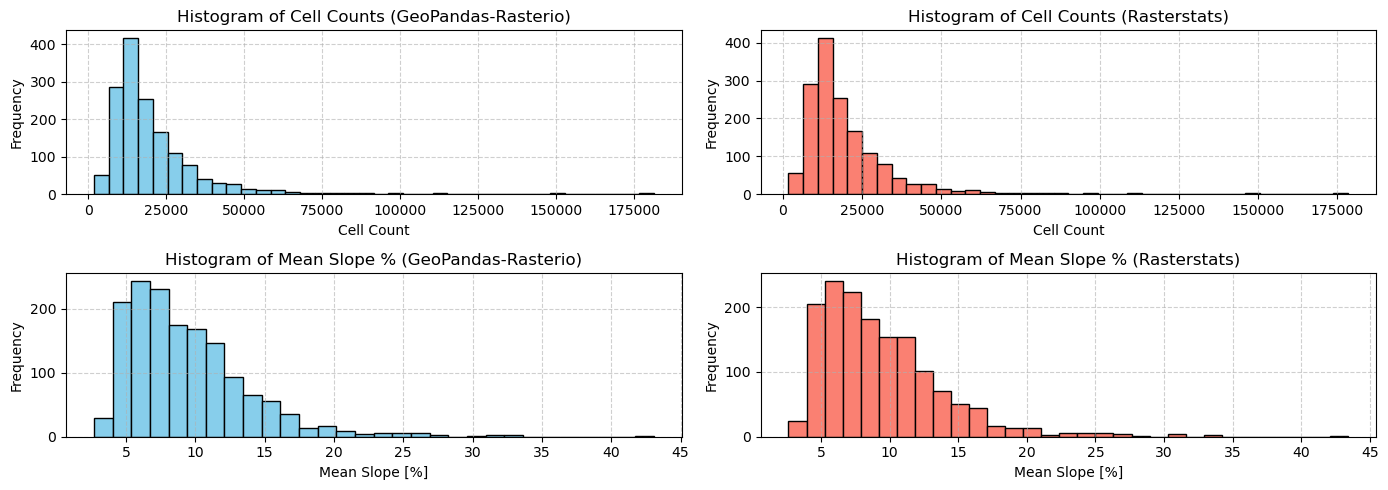

In [39]:
# Plot histograms side by side
# Use the scott rule for binning (bins='scott') 
fig, ax = plt.subplots(2, 2, figsize=(14, 5))

# Add grid lines to all subplots
for row in ax:
    for a in row:
        a.grid(True, linestyle='--', alpha=0.6)

# Histogram for count_gpd-rio
ax[0][0].hist(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].dropna(), bins='scott', color='skyblue', edgecolor='black')
ax[0][0].set_title('Histogram of Cell Counts (GeoPandas-Rasterio)')
ax[0][0].set_xlabel('Cell Count')
ax[0][0].set_ylabel('Frequency')

# Histogram for count_rstats
ax[0][1].hist(redmond_roads_gdf_50ft_rs_join['count_rstats'].dropna(), bins='scott', color='salmon', edgecolor='black')
ax[0][1].set_title('Histogram of Cell Counts (Rasterstats)')
ax[0][1].set_xlabel('Cell Count')
ax[0][1].set_ylabel('Frequency')

# Histogram for mean_gpd-rio
ax[1][0].hist(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].dropna(), bins='scott', color='skyblue', edgecolor='black')
ax[1][0].set_title('Histogram of Mean Slope % (GeoPandas-Rasterio)')
ax[1][0].set_xlabel('Mean Slope [%]')
ax[1][0].set_ylabel('Frequency')

# Histogram for mean_rstats
ax[1][1].hist(redmond_roads_gdf_50ft_rs_join['mean_rstats'].dropna(), bins='scott', color='salmon', edgecolor='black')
ax[1][1].set_title('Histogram of Mean Slope % (Rasterstats)')
ax[1][1].set_xlabel('Mean Slope [%]')
ax[1][1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

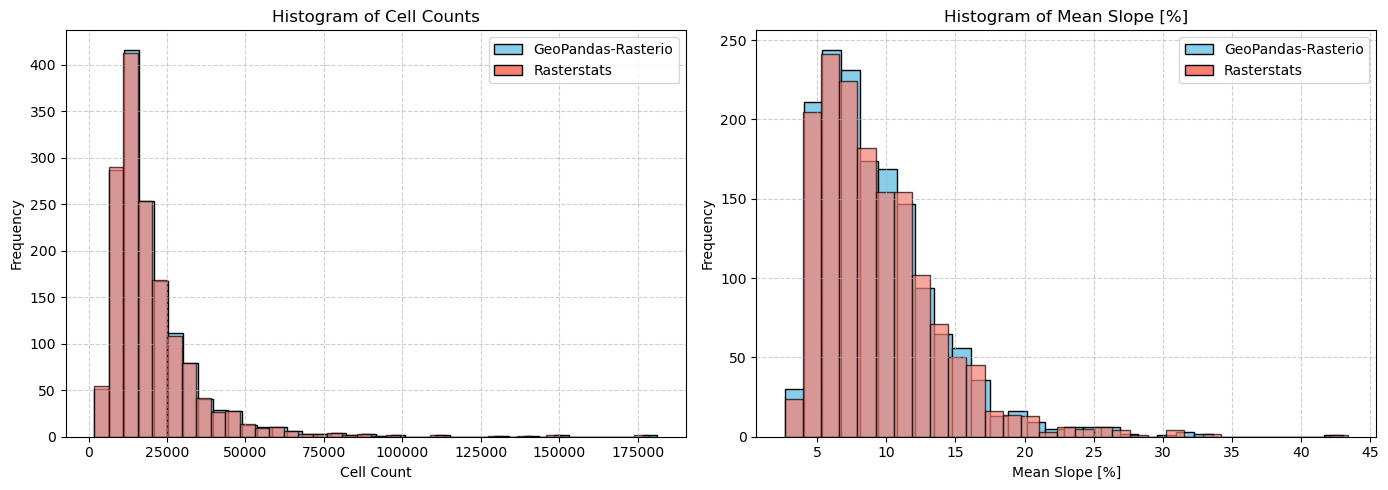

In [40]:
# Plot the histograms stacked
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Histogram for cell counts
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].dropna(), bins='scott', color='skyblue', edgecolor='black')
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_rstats'].dropna(), bins='scott', color='salmon', edgecolor='black', alpha=0.7)
ax[0].set_title('Histogram of Cell Counts')
ax[0].set_xlabel('Cell Count')
ax[0].set_ylabel('Frequency')

# Histogram for mean slope
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].dropna(),  bins='scott', color='skyblue', edgecolor='black')
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_rstats'].dropna(), bins='scott', color='salmon', edgecolor='black', alpha=0.7)
ax[1].set_title('Histogram of Mean Slope [%]')
ax[1].set_xlabel('Mean Slope [%]')
ax[1].set_ylabel('Frequency')


# Add legends 
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='GeoPandas-Rasterio'),
    Patch(facecolor='salmon', edgecolor='black', label='Rasterstats')
]
ax[0].legend(handles=legend_elements, loc='upper right')
ax[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


The distributions of cell counts and mean slope appear to have similar trends. We used the same zones for each method, how would having more cells within the zones influence mean slope values?


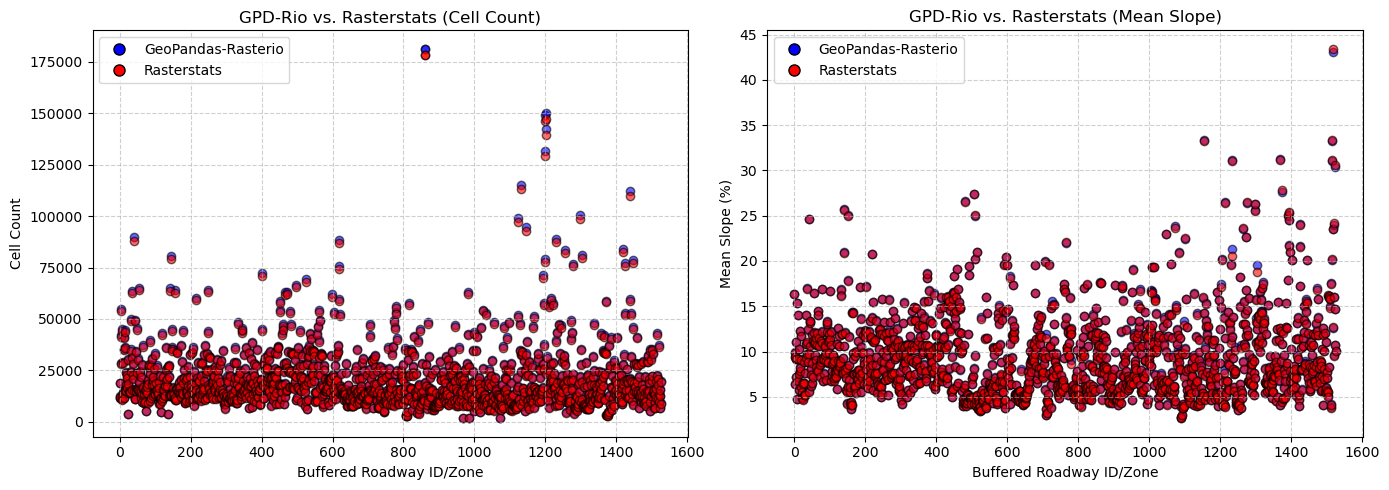

In [41]:
# Scatterplots of cell counts and mean slope within buffered roadways
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Scatterplot for GeoPandas-Rasterio cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_rstats'], alpha=0.6, color='red', edgecolor='black')
ax[0].set_title('GPD-Rio vs. Rasterstats (Cell Count)')
ax[0].set_xlabel('Buffered Roadway ID/Zone')
ax[0].set_ylabel('Cell Count')

# Scatterplot for GeoPandas-Rasterio mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.6, color='red', edgecolor='black')
ax[1].set_title('GPD-Rio vs. Rasterstats (Mean Slope)')
ax[1].set_xlabel('Buffered Roadway ID/Zone')
ax[1].set_ylabel('Mean Slope (%)')

# Make a legend with dot markers
dot_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GeoPandas-Rasterio',
           markerfacecolor='blue', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Rasterstats',
           markerfacecolor='red', markeredgecolor='black', markersize=8)
]
ax[0].legend(handles=dot_legend_elements, loc='upper left')
ax[1].legend(handles=dot_legend_elements, loc='upper left')
plt.tight_layout()
plt.show()

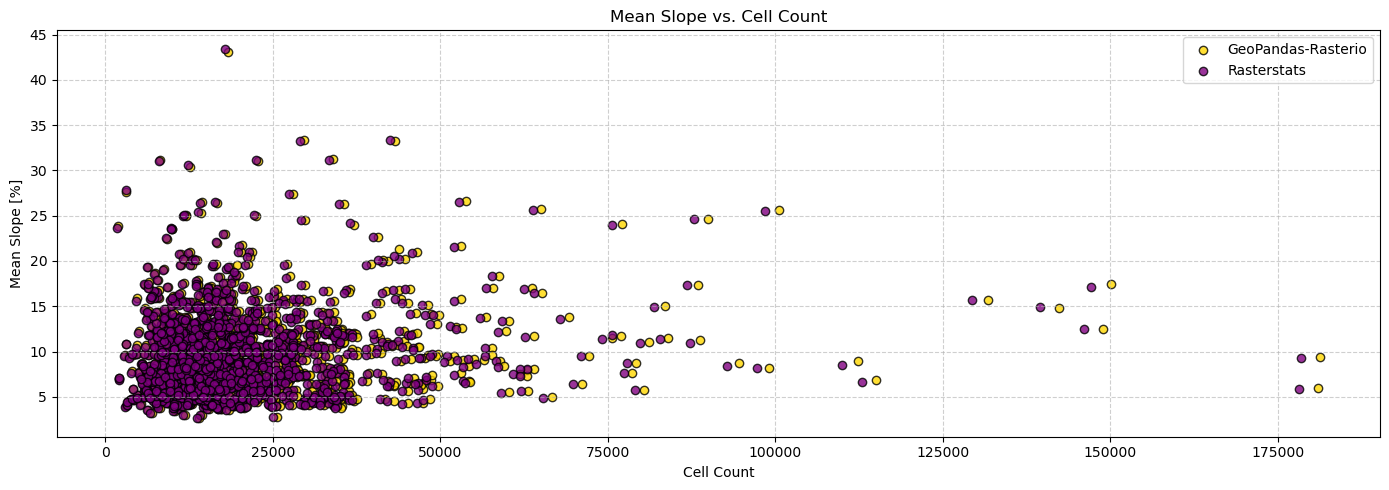

In [42]:
# Make a scatter plot of mean slope vs. cell count
fig, ax = plt.subplots(figsize=(14, 5))

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.6)

# Scatter plots
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.8, color='gold', edgecolor='black', label='GeoPandas-Rasterio')
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_rstats'], redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.8, color='purple', edgecolor='black', label='Rasterstats')

ax.set_title('Mean Slope vs. Cell Count')
ax.set_xlabel('Cell Count')
ax.set_ylabel('Mean Slope [%]')
ax.legend()

plt.tight_layout()
plt.show()


The scatter plots demonstrate a shift in values obtained for each zone.



**Set all_touched to False?**


In [43]:
# Function to create a masked array for slope data with all_touched=False
def slope_masked_array_2(geom, data=redmond_slope_perc, **mask_args):
    slope_masked_2, slope_mask_transform_2 = mask(dataset=data, shapes=[geom],
                                  crop=True, all_touched=False, filled=False, indexes=1)
    return slope_masked_2

In [44]:
# Zonal statistics for roadways with all_touched=False
redmond_roads_gdf_50ft_rs_join['count_gpd-rio'] = redmond_roads_gdf_50ft_rs_join.geometry.apply(slope_masked_array_2).apply(cell_count)
redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'] = redmond_roads_gdf_50ft_rs_join.geometry.apply(slope_masked_array_2).apply(np.mean)
redmond_roads_gdf_50ft_rs_join['std_gpd-rio'] = redmond_roads_gdf_50ft_rs_join.geometry.apply(slope_masked_array_2).apply(np.std)
redmond_roads_gdf_50ft_rs_join

,StreetName,FromStreet,ToStreet,length_ft,geometry,count_gpd-rio,mean_gpd-rio,std_gpd-rio,count_rstats,mean_rstats,std_rstats
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",18676,16.362584,18.080509,18676,16.362584,18.080509
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11440,9.874168,5.675154,11440,9.874168,5.675154
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12276,6.410288,5.351420,12276,6.410288,5.351420
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28318,9.432054,7.865597,28318,9.432054,7.865597
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41280,11.067454,10.761327,41280,11.067454,10.761327
...,...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6742,16.006290,18.463713,6742,16.006290,18.463713
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12396,30.572715,23.143212,12396,30.572715,23.143212
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15654,10.761567,13.932122,15654,10.761567,13.932122
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8794,14.657086,15.633074,8794,14.657086,15.633074


In [45]:
# Create a DataFrame to compare statistics of mean slope values
mean_stats_df_2 = pd.DataFrame({
    'GeoPandas-Rasterio Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].describe(),
    'Rasterstats Mean Slope': redmond_roads_gdf_50ft_rs_join['mean_rstats'].describe()
})

mean_stats_df_2['Difference'] = mean_stats_df_2['GeoPandas-Rasterio Mean Slope'] - mean_stats_df_2['Rasterstats Mean Slope']
mean_stats_df_2

,GeoPandas-Rasterio Mean Slope,Rasterstats Mean Slope,Difference
count,1527.000000,1527.000000,0.0
mean,9.366920,9.366920,0.0
std,4.465950,4.465950,0.0
min,2.634842,2.634842,0.0
25%,6.150750,6.150750,0.0
50%,8.319216,8.319216,0.0
75%,11.580883,11.580883,0.0
max,43.421248,43.421248,0.0


In [46]:
# Create a DataFrame to compare statistics of counts
counts_stats_df_2 = pd.DataFrame({
    'GeoPandas-Rasterio Cell Count': redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].describe(),
    'Rasterstats Cell Count': redmond_roads_gdf_50ft_rs_join['count_rstats'].describe()
})

counts_stats_df_2['Difference'] = counts_stats_df_2['GeoPandas-Rasterio Cell Count'] - counts_stats_df_2['Rasterstats Cell Count']
counts_stats_df_2

,GeoPandas-Rasterio Cell Count,Rasterstats Cell Count,Difference
count,1527.000000,1527.000000,0.0
mean,20233.616241,20233.616241,0.0
std,15644.507226,15644.507226,0.0
min,1753.000000,1753.000000,0.0
25%,11484.000000,11484.000000,0.0
50%,15802.000000,15802.000000,0.0
75%,24021.000000,24021.000000,0.0
max,178420.000000,178420.000000,0.0


In [47]:
# Create a df that is the difference between the GeoPandas-Rasterio and Rasterstats results
difference_df = redmond_roads_gdf_50ft_rs_join.copy()
difference_df['count_diff'] = difference_df['count_gpd-rio'] - difference_df['count_rstats']
difference_df['mean_diff'] = difference_df['mean_gpd-rio'] - difference_df['mean_rstats']
difference_df['std_diff'] = difference_df['std_gpd-rio'] - difference_df['std_rstats']
difference_df

,StreetName,FromStreet,ToStreet,length_ft,geometry,count_gpd-rio,mean_gpd-rio,std_gpd-rio,count_rstats,mean_rstats,std_rstats,count_diff,mean_diff,std_diff
0,NE 116th ST,167th PL NE,167th PL NE,341.619702,"POLYGON ((1324375.025 259430.934, 1324379.918 ...",18676,16.362584,18.080509,18676,16.362584,18.080509,0,0.0,0.0
1,NE 116th ST,176th PL NE,176th AVE NE,178.804762,"POLYGON ((1327083.655 259358.493, 1327232.295 ...",11440,9.874168,5.675154,11440,9.874168,5.675154,0,0.0,0.0
2,NE 114th CT,W of 159th AVE NE,159th AVE NE,203.045037,"POLYGON ((1321674.046 259077.955, 1321674.451 ...",12276,6.410288,5.351420,12276,6.410288,5.351420,0,0.0,0.0
3,NE 114th ST,W of 148th AVE NE,148th AVE NE,558.420606,"POLYGON ((1318098.49 258745.577, 1318099.367 2...",28318,9.432054,7.865597,28318,9.432054,7.865597,0,0.0,0.0
4,RED-WOOD RD NE,NE 113th CT,NE 116th ST,849.987710,"POLYGON ((1320641.017 259499.219, 1320641.469 ...",41280,11.067454,10.761327,41280,11.067454,10.761327,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,NE 69th CIR,NE 69th CIR,NE 69th CIR,72.982265,"POLYGON ((1332322.631 245646.177, 1332320.234 ...",6742,16.006290,18.463713,6742,16.006290,18.463713,0,0.0,0.0
1523,192nd AVE NE,191st AVE NE,NE 69th CIR,200.388212,"POLYGON ((1332161.941 245707.139, 1332161.916 ...",12396,30.572715,23.143212,12396,30.572715,23.143212,0,0.0,0.0
1524,NE 69th CIR,NE 69th CIR,NE 70th ST,273.480225,"POLYGON ((1332332.166 245895.207, 1332332.804 ...",15654,10.761567,13.932122,15654,10.761567,13.932122,0,0.0,0.0
1525,NE 69th CIR,NE 69th CIR,NE 69th CIR,118.897504,"POLYGON ((1332304.664 245830.908, 1332304.668 ...",8794,14.657086,15.633074,8794,14.657086,15.633074,0,0.0,0.0


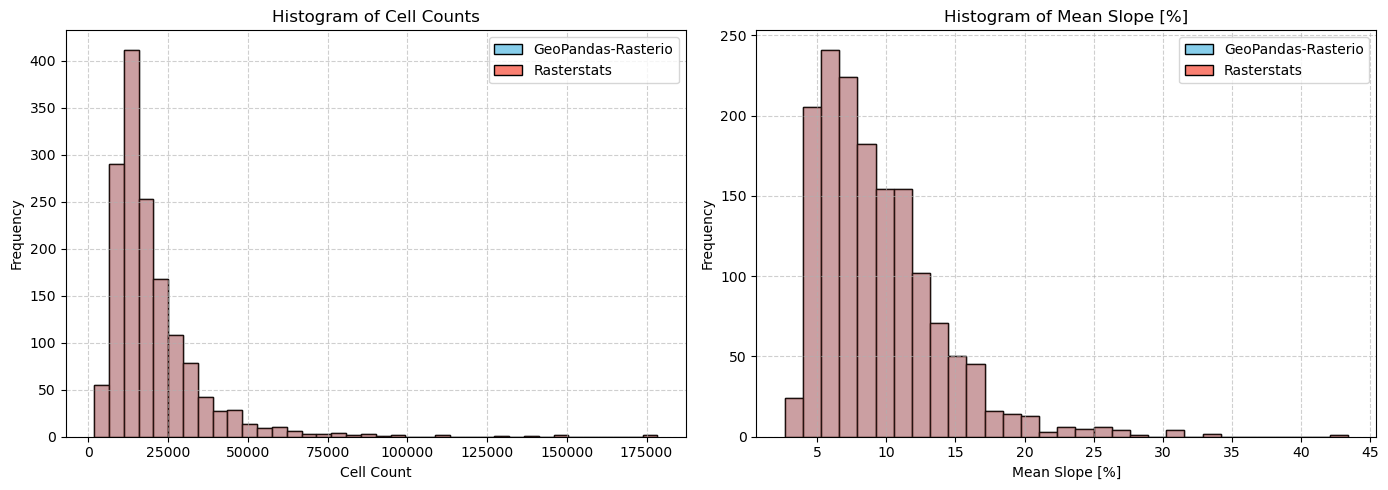

In [48]:
# Plot the histograms stacked
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Histogram for cell counts
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'].dropna(), bins='scott', color='skyblue', edgecolor='black')
ax[0].hist(redmond_roads_gdf_50ft_rs_join['count_rstats'].dropna(), bins='scott', color='salmon', edgecolor='black', alpha=0.6)
ax[0].set_title('Histogram of Cell Counts')
ax[0].set_xlabel('Cell Count')
ax[0].set_ylabel('Frequency')

# Histogram for mean slope
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'].dropna(),  bins='scott', color='skyblue', edgecolor='black')
ax[1].hist(redmond_roads_gdf_50ft_rs_join['mean_rstats'].dropna(), bins='scott', color='salmon', edgecolor='black', alpha=0.6)
ax[1].set_title('Histogram of Mean Slope [%]')
ax[1].set_xlabel('Mean Slope [%]')
ax[1].set_ylabel('Frequency')


# Add legends 
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='GeoPandas-Rasterio'),
    Patch(facecolor='salmon', edgecolor='black', label='Rasterstats')
]
ax[0].legend(handles=legend_elements, loc='upper right')
ax[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

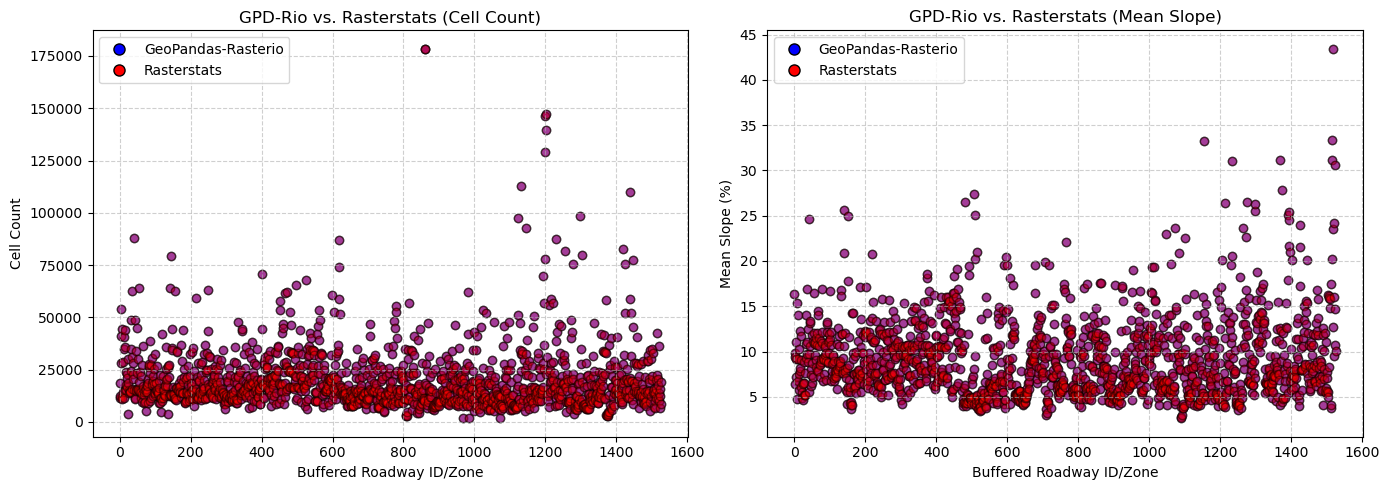

In [49]:
# Scatterplots of cell counts and mean slope within buffered roadways
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add grid lines to all subplots
for a in ax:
    a.grid(True, linestyle='--', alpha=0.6)

# Scatterplot for GeoPandas-Rasterio cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats cell counts
ax[0].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['count_rstats'], alpha=0.4, color='red', edgecolor='black')
ax[0].set_title('GPD-Rio vs. Rasterstats (Cell Count)')
ax[0].set_xlabel('Buffered Roadway ID/Zone')
ax[0].set_ylabel('Cell Count')

# Scatterplot for GeoPandas-Rasterio mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.6, color='blue', edgecolor='black')

# Scatterplot for Rasterstats mean slope
ax[1].scatter(redmond_roads_gdf_50ft_rs_join.index, redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.4, color='red', edgecolor='black')
ax[1].set_title('GPD-Rio vs. Rasterstats (Mean Slope)')
ax[1].set_xlabel('Buffered Roadway ID/Zone')
ax[1].set_ylabel('Mean Slope (%)')

# Make a legend with dot markers
dot_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GeoPandas-Rasterio',
           markerfacecolor='blue', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Rasterstats',
           markerfacecolor='red', markeredgecolor='black', markersize=8)
]
ax[0].legend(handles=dot_legend_elements, loc='upper left')
ax[1].legend(handles=dot_legend_elements, loc='upper left')
plt.tight_layout()
plt.show()

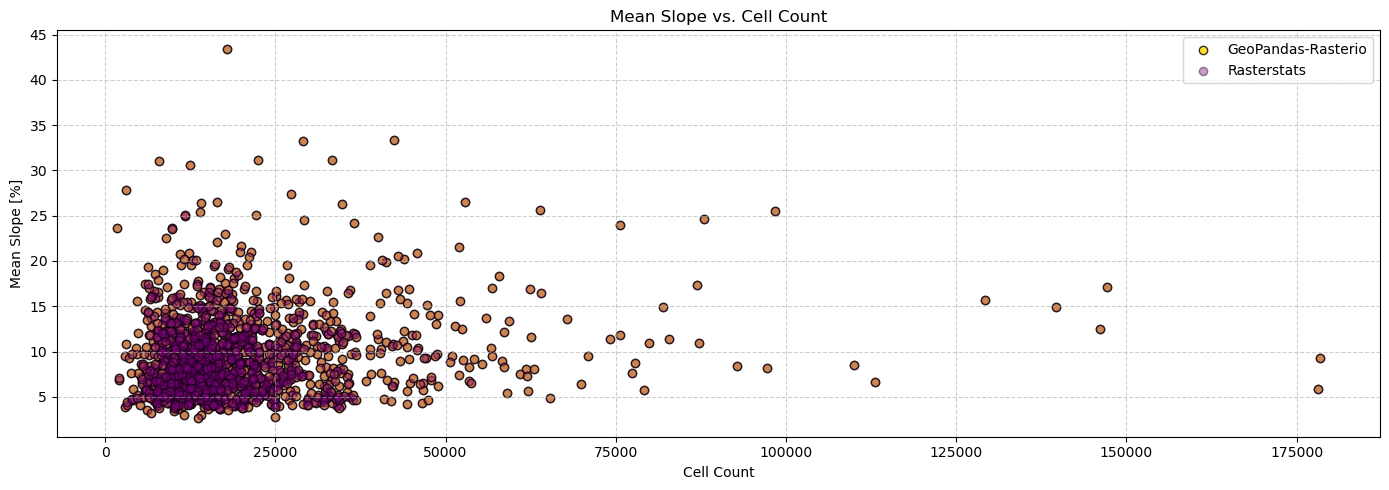

In [50]:
# Make a scatter plot of mean slope vs. cell count
fig, ax = plt.subplots(figsize=(14, 5))

# Add grid lines to the subplot
ax.grid(True, linestyle='--', alpha=0.6)

# Scatter plots
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_gpd-rio'], redmond_roads_gdf_50ft_rs_join['mean_gpd-rio'], alpha=0.8, color='gold', edgecolor='black', label='GeoPandas-Rasterio')
ax.scatter(redmond_roads_gdf_50ft_rs_join['count_rstats'], redmond_roads_gdf_50ft_rs_join['mean_rstats'], alpha=0.4, color='purple', edgecolor='black', label='Rasterstats')

ax.set_title('Mean Slope vs. Cell Count')
ax.set_xlabel('Cell Count')
ax.set_ylabel('Mean Slope [%]')
ax.legend()

plt.tight_layout()
plt.show()

### Final Thoughts and Considerations

The GeoPandas-Rasterio method achieves identical results to Rasterstats when all_touched is False. Rasterstats has all_touched set to False by default, which counts cells if their centers are within a geometry. If all_touched is True, every cell is counted if it falls within a geometry, regardless of the center. You can read about the implications of having too few or too many cells for zonal statistics in other resources, but understanding the options and parameters available with any tool can help obtain meaningful analytics. Learning how to customize tools also prepares you for scenarios where you might need to explore other methods or options to acomplish a task.


### Saving Outputs to Files

Before moving on to the other scripts in the repository, save the buffered roads with the zonal statistics. You could compare these to what you get from anything ArcGIS-related, QGIS, SAGA GIS, PostGIS, or GRASS GIS...that one scares me the most.

In [51]:
# Set output directory
outputs_dir = os.path.join(ipynb_dir, "Outputs")
os.makedirs(outputs_dir, exist_ok=True)

# Uncomment the line below the file type comment for the desired format

# Esri Shapefile
#redmond_roads_gdf_50ft.to_file(os.path.join(outputs_dir, "Redmond_Roads_Slope_Stats.shp"), driver='ESRI Shapefile')

# GeoPackage
#redmond_roads_gdf_50ft.to_file(os.path.join(outputs_dir, "Redmond_Roads_Slope_Stats.gpkg"), driver='GPKG')

# GeoJSON
redmond_roads_gdf_50ft.to_file(os.path.join(outputs_dir, "Redmond_Roads_Slope_Stats.geojson"), driver='GeoJSON')

# File Geodatabase
#redmond_roads_gdf_50ft.to_file(os.path.join(outputs_dir, "Redmond_Roads_Slope_Stats.gdb"), driver='OpenFileGDB')